In [ ]:
#!pip install tensorflow

In [ ]:
# Imports
import os
import time
import shutil
import numpy as np
from tqdm import tqdm
from scipy.linalg import sqrtm
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Concatenate, Embedding, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, Dropout

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam

In [ ]:
# Parameters
ALPHA = 0.2
GAUSS_SD = 0.02
MOMENTUM = 0.9
DROPOUT = 0.4

ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.99
GEN_LEARNING_RATE = 0.0001
DIS_LEARNING_RATE = 0.0004

MAX_ITER = 30000
NUM_CLASSES = 10
SAVE_PERIOD = 250
TRAIN_BATCH_SIZE = 128
EVAL_BATCH_SIZE = 128
FID_BATCH_SIZE = 1000

LATENT_DIM = 100
GENERATOR_INPUT = (100,)
DISCRIMINATOR_INPUT = (32, 32, 3)
INCEPTION_SHAPE = (299, 299, 3)

GRID_SIZE = 8
GRID_IMGS = 64  # GRID_SIZE * GRID_SIZE

In [ ]:
# Create save directories
os.makedirs('SAGAN', exist_ok=True)
os.makedirs('./SAGAN/train_images', exist_ok=True)


In [ ]:
# The following Spectral normalization code has been adapted from Github
#https://github.com/jason71995/tf2_gan_library/blob/master/gan_lib/sngan.py

class ConvSN2D(Conv2D):
    def __init__(
            self,
            filters,
            kernel_size,
            strides=(1, 1),
            padding='valid',
            data_format=None,
            dilation_rate=(1, 1),
            activation=None,
            use_bias=True,
            kernel_initializer='glorot_uniform',
            bias_initializer='zeros',
            kernel_regularizer=None,
            bias_regularizer=None,
            activity_regularizer=None,
            # kernel_constraint=None,
            bias_constraint=None,
            power_iterations = 1,
            **kwargs):

        super(ConvSN2D, self).__init__(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            dilation_rate=dilation_rate,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=self.spectrally_norm,
            bias_constraint=bias_constraint,
            **kwargs)

        assert power_iterations>=1, "The number of power iterations should be positive integer"

        self.Ip = power_iterations
        self.u = self.add_weight(
            name='W_u',
            shape=(1, filters),
            initializer='random_uniform',
            trainable=False
        )

    def spectrally_norm(self, w):
        W_mat = tf.transpose(w, (3, 2, 0, 1))  # (h, w, i, o) => (o, i, h, w)
        W_mat = tf.reshape(W_mat, [tf.shape(W_mat)[0], -1])  # (o, i * h * w)

        _u = self.u
        _v = None

        for _ in range(self.Ip):
            _v = self.l2_norm(tf.matmul(_u, W_mat))
            _u = self.l2_norm(tf.matmul(_v, W_mat, transpose_b=True))

        sigma = tf.reduce_sum(tf.matmul(_u, W_mat) * _v)
        sigma = tf.cond(sigma == 0, lambda: 1e-8, lambda: sigma)

        self.u.assign(tf.keras.backend.in_train_phase(_u, self.u))
        return w / sigma

    def l2_norm(self, x):
        return x / tf.sqrt(tf.reduce_sum(tf.square(x)) + 1e-8)


# Self Attention layer
class SelfAttention(Layer):
    def __init__(self, reduced_filters, **kwargs):
        self.reduced_filters = reduced_filters
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w_f = self.add_weight(name='kernal_w_f',
                                   shape=(1, 1, input_shape[-1], self.reduced_filters),
                                   initializer='glorot_uniform',
                                   trainable=True)

        self.w_g = self.add_weight(name='kernal_w_g',
                                   shape=(1, 1, input_shape[-1], self.reduced_filters),
                                   initializer='glorot_uniform',
                                   trainable=True)

        self.w_h = self.add_weight(name='kernal_w_h',
                                   shape=(1, 1, input_shape[-1], self.reduced_filters),
                                   initializer='glorot_uniform',
                                   trainable=True)

        self.w_v = self.add_weight(name='kernal_w_v',
                                   shape=(1, 1, self.reduced_filters, input_shape[-1]),
                                   initializer='glorot_uniform',
                                   trainable=True)

        self.gamma = self.add_weight(name='gamma',
                                     shape=(1, ),
                                     initializer='zero',
                                     trainable=True)

        super(SelfAttention, self).build(input_shape)

    def call(self, x):
        x_shape = tf.shape(x)
        x_f = tf.keras.backend.conv2d(x, self.w_f, padding="same")
        x_g = tf.keras.backend.conv2d(x, self.w_g, padding="same")
        x_h = tf.keras.backend.conv2d(x, self.w_h, padding="same")

        x_f = tf.reshape(x_f, (x_shape[0], x_shape[1] * x_shape[2], -1))
        x_g = tf.reshape(x_g, (x_shape[0], x_shape[1] * x_shape[2], -1))
        x_h = tf.reshape(x_h, (x_shape[0], x_shape[1] * x_shape[2], -1))

         # Attention map
        y = tf.matmul(x_f, x_g, transpose_b=True)
        y = tf.nn.softmax(y, axis = 1)
        y = tf.matmul(y, x_h)
        y = tf.reshape(y, (x_shape[0], x_shape[1], x_shape[2], -1))
        y = tf.keras.backend.conv2d(y,self.w_v,padding="same")
        y = self.gamma * y + x
        return y

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
def preprocess(image):
    """
    Converts the pixel values to the interval [-1. 1]
    :param image: Image matrix
    :return: Scaled images
    """
    return (image / 255) * 2 - 1


def generate_latent_samples(n_samples, sample_size):  
    """
    Creates latent samples to be fed into the generator
    :param n_samples: Number of samples to be generated
    :param sample_size: Dimesion on each sample
    :return: Latent samples of given size
    """
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))


def generate_labels(n_samples):
    """
    Generates an array of ones(TRUE) and zeroes(FALSE) labels
    :param n_samples: The number of samples
    :return: Labels
    """
    return np.ones([n_samples, 1]), np.zeros([n_samples, 1])


def smooth_positive_labels(y):
    """
    Label smoothing postive labels to [0.9, 1.0]
    :param y: label
    :return: Smoothed labels
    """
    return y - 0.1 + (np.random.random(y.shape) * 0.1)


def smooth_negative_labels(y):
    """
    Label smoothing postive labels to [0, 0.1]
    :param y: label
    :return: Smoothed labels
    """
    return y + (np.random.random(y.shape) * 0.1)

    
def wasserstein_loss(y_true, y_pred):
    """
    Wassertein Loss function
    :param y_true: True labels
    :param y_pred: Predicted labels
    """
    return K.mean(y_true * y_pred)

In [ ]:
def plot_image_grid(epoch, generated_images):
    """
    Plots the grid of images generated and end of each epoch
    :param epoch: the epoch number
    :param generated_images: List of generated images (atleast GRID_IMGS)
    :return: None
    """

    fig = plt.figure(figsize=(GRID_SIZE, GRID_SIZE))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.001, hspace=0.001)

    for ind in range(GRID_IMGS):
        ax = fig.add_subplot(GRID_SIZE, GRID_SIZE, ind + 1, xticks=[], yticks=[])
        ax.imshow(np.uint8(((generated_images[ind] + 1) / 2) * 255), cmap='gray')

    plt.savefig('./SAGAN/train_images/image_iteration_{:05d}.png'.format(epoch + 1))
    plt.close()


def plot_final_grid(generated_images):
    """
    Plots the grid of images generated from final model
    :param generated_images: List of generated images (atleast GRID_IMGS)
    :return: None
    """

    fig = plt.figure(figsize=(GRID_SIZE, GRID_SIZE))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.001, hspace=0.001)

    for ind in range(GRID_IMGS):
        ax = fig.add_subplot(GRID_SIZE, GRID_SIZE, ind + 1, xticks=[], yticks=[])
        ax.imshow(np.uint8(((generated_images[ind] + 1) / 2) * 255), cmap='gray')

    plt.savefig('./SAGAN/generated_image_grid.png')
    plt.savefig('./results/SAGAN.png')
    plt.show()

In [ ]:
# The following FID calculation code has been adapted from Machine learning mastery
# https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

# Inceptionv3 model for FID calculation
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception = InceptionV3(include_top=False, pooling='avg', input_shape=INCEPTION_SHAPE)


def scale_images(images, new_shape):
    """
    Scales images into new shape by interpolation since inception model requires that
    :param images: List of images
    :param new_shape: The transformed shape
    :return: Transformed images
    """

    images_list = list()

    for image in images:
        new_image = resize(image, new_shape)
        images_list.append(new_image)
    
    return np.asarray(images_list)


def calculate_fid(model, images1, images2):
    """

    Calculates the FID with the inception last layer activations
    :param model: THe model (eg: inception)
    :param images1: List of images grouo 1
    :param images1: List of images grouo 2
    :return: FID score
    """
    
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Equation for FID score calculation
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)  

    return fid

In [ ]:
def discriminator_model():  
    """
    Create and return a discriminator model
    :return: discriminator model
    """

    img_input = Input(shape=DISCRIMINATOR_INPUT)   
    labels = Input(shape=[1])

    embedded_id = Embedding(input_dim=10, output_dim=50)(labels)   
    embedded_id = Dense(units=img_input.shape[1] * img_input.shape[2])(embedded_id)    
    embedded_id = Flatten()(embedded_id)

    # Downsampling : 32x32x3 --> 16x16x64
    D = ConvSN2D(64, kernel_size=5, strides=2, padding='same', use_bias = False, kernel_initializer=RandomNormal(stddev=GAUSS_SD), input_shape=DISCRIMINATOR_INPUT)(img_input)
    D = LeakyReLU(ALPHA)(D)    

    D = SelfAttention(64)(D)
 
    # Downsampling : 16x16x64 --> 8x8x128
    D = ConvSN2D(128, kernel_size=5, strides=2, padding="same", kernel_initializer=RandomNormal(stddev=GAUSS_SD), use_bias=False)(D)
    D = BatchNormalization(momentum=MOMENTUM)(D)
    D = LeakyReLU(ALPHA)(D)

    # Downsampling : 8x8x128 --> 4x4x256
    D = ConvSN2D(256, kernel_size=5, strides=2, padding="same", kernel_initializer=RandomNormal(stddev=GAUSS_SD), use_bias=False)(D)
    D = BatchNormalization(momentum=MOMENTUM)(D)
    D = LeakyReLU(ALPHA)(D)

    # Downsampling : 4x4x256 --> 2x2x512
    D = ConvSN2D(512, kernel_size=5, strides=2, padding="same", kernel_initializer=RandomNormal(stddev=GAUSS_SD), use_bias=False)(D)
    D = BatchNormalization(momentum=MOMENTUM)(D)
    D = LeakyReLU(ALPHA)(D)

    # Fully Connected Layer (classifier) , 2x2x512 (2048) --> 1
    D = Flatten()(D)
    merged_layer = Concatenate()([D, embedded_id])

    D = Dense(512, activation='relu')(merged_layer)
    D = Dense(1, activation='sigmoid')(D)
    Discriminator = Model(inputs=[img_input, labels], outputs=D, name = 'Discriminator')
   
    return Discriminator


def generator_model():
    """
    Create and return a discriminator model
    :return: discriminator model
    """

    z = Input(shape=GENERATOR_INPUT)
    labels = Input(shape=[1])

    embedded_id = Embedding(input_dim=10, output_dim=50)(labels)
    embedded_id = Dense(units=2 * 2)(embedded_id)
    embedded_id = Reshape(target_shape=(2, 2, 1))(embedded_id)

    # Fully Connected layer --> 512 activation maps of 2x2  
    G = Dense(2*2*512, activation='relu')(z)
    G = Reshape((2, 2, 512))(G)
    G = BatchNormalization(momentum=MOMENTUM)(G)
    G = LeakyReLU(ALPHA)(G)
    
    G = Concatenate()([G, embedded_id])
    
    # Upsampling : 2x2x512 --> 4x4x256 
    G = UpSampling2D((2, 2))(G)
    G = ConvSN2D(256, kernel_size=5, strides=1, padding='same', kernel_initializer=RandomNormal(stddev=GAUSS_SD))(G)
    G = BatchNormalization(momentum=MOMENTUM)(G)
    G = LeakyReLU(ALPHA)(G)

    # Upsampling : 4x4x256 --> 8x8x128 
    G = UpSampling2D((2, 2))(G)
    G = ConvSN2D(128, kernel_size=5, strides=1, padding='same', kernel_initializer=RandomNormal(stddev=GAUSS_SD))(G)
    G = BatchNormalization(momentum=MOMENTUM)(G)
    G = LeakyReLU(ALPHA)(G)
  
    # Upsampling : 8x8x128 --> 16x16x64
    G = UpSampling2D((2, 2))(G)
    G = ConvSN2D(64, kernel_size=5, strides=1, padding='same', kernel_initializer=RandomNormal(stddev=GAUSS_SD))(G)
    G = BatchNormalization(momentum=MOMENTUM)(G)
    G = LeakyReLU(ALPHA)(G)
    
    G = SelfAttention(64)(G)
    
    # Upsampling : 16x16x63 --> 32x32x3
    G = UpSampling2D((2, 2))(G)
    G = ConvSN2D(3, kernel_size=5, strides=1, padding='same', activation='tanh')(G) 

    Generator = Model(inputs=[z, labels], outputs=G, name = 'Generator')

    return Generator


def SAGAN_model():
    """
    Creates and returns the GAN, gnerator and discriminator models
    :return: GAN, gnerator and discriminator models
    """
    
    # Generator model
    Generator = generator_model()
    
    # Discriminator model
    Discriminator = discriminator_model()
    Discriminator.compile(optimizer=Adam(lr=DIS_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2), loss = wasserstein_loss, metrics=['accuracy'])

    z = Input(shape=(100,), name='z')
    label = Input(shape=(1,), name='label')

    fake_img = Generator([z, label])
    validity = Discriminator([fake_img, label])

    # GAN model
    GAN = Model([z, label], validity, name='GAN')
    GAN.compile(optimizer=Adam(lr=GEN_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2), loss = wasserstein_loss, metrics=['accuracy'])

    return GAN, Generator, Discriminator

In [ ]:
def train_SAGAN():
    """
    Function to train the GAN, gnerator and discriminator models
    """

    best_fid_score = 10000
    if os.path.exists('./SAGAN/best_fid_score.txt'):
        best_fid_score = float(next(open('best_fid.txt')))
        print('Best FID Score :', best_fid_score)

    # Calculate the previous iteration counts if the model was trained before
    prev_iters = 0
    if os.path.exists('./SAGAN/fid_scores.txt'):
        prev_iters = (sum(1 for line in open('fid_scores.txt'))) * SAVE_PERIOD
        print('Previous iteration count :', prev_iters)

    # Generate labels for training and evaluation batches
    Y_train_real, Y_train_fake = generate_labels(TRAIN_BATCH_SIZE)
    Y_eval_real, Y_eval_fake = generate_labels(EVAL_BATCH_SIZE)

    # Load existing model if exists or create a new model
    if os.path.exists('./model/SAGAN/best_GAN'):
        print("Saved model found. Loading model.")

        generator = load_model('./model/SAGAN/best_generator', custom_objects={'wasserstein_loss': wasserstein_loss})
        print("Loaded Generator")

        discriminator = load_model('./model/SAGAN/best_discriminator', custom_objects={'wasserstein_loss': wasserstein_loss})
        print("Loaded Discriminator")
        #cus obj
        GAN = load_model('./model/SAGAN/best_GAN', custom_objects={'wasserstein_loss': wasserstein_loss})
        print("Loaded GAN")

        discriminator.compile(optimizer=Adam(lr=DIS_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2), loss = wasserstein_loss, metrics=['accuracy'])
        GAN.compile(optimizer=Adam(lr=GEN_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2), loss = wasserstein_loss, metrics=['accuracy'])

    else:
        GAN, generator, discriminator = SAGAN_model()
        print("Created new GAN, Generator and Discriminator")

    for iters in range(MAX_ITER):
        print("Iteration : ", iters + prev_iters)

        # TRAIN - DISCRIMINATOR MODEL
        discriminator.trainable = True

        # Sample a train subset from real images
        rand_list = np.random.choice(X_train.shape[0], TRAIN_BATCH_SIZE, replace=True)
        X_batch_real = X_train[rand_list, :]
        X_real_labels = Y_train[rand_list, :].reshape(-1, 1)

        # Generate fake samples
        latent_samples = generate_latent_samples(TRAIN_BATCH_SIZE, 100)
        random_labels  = np.random.randint(0, 10, TRAIN_BATCH_SIZE).reshape(-1, 1)  
        X_batch_fake = generator.predict_on_batch([latent_samples, random_labels])

        # Train the discriminator to detect real and fake images
        discriminator.train_on_batch([X_batch_real, X_real_labels], Y_train_real)
        discriminator.train_on_batch([X_batch_fake, random_labels], Y_train_fake)

        # TRAIN - GENERATOR MODEL
        discriminator.trainable = False
        GAN.train_on_batch([latent_samples, random_labels], Y_train_real)

        # Calculate and record loss, FID for every SAVE_PERIOD iterations
        if (iters + 1) % SAVE_PERIOD == 0:
            # Generate latent samples
            latent_samples = generate_latent_samples(EVAL_BATCH_SIZE, 100)
            random_labels  = np.random.randint(0, 10, EVAL_BATCH_SIZE).reshape(-1, 1)
            GAN_images = generator.predict_on_batch([latent_samples, random_labels])

            # Sample a subset of test images
            rand_list = np.random.choice(X_test.shape[0], EVAL_BATCH_SIZE, replace=True)
            X_eval_real = X_test[rand_list, :]
            X_eval_lables = Y_test[rand_list, :].reshape(-1, 1)

            # Calculating losses
            discriminator_loss_real = discriminator.test_on_batch([X_eval_real, X_eval_lables], Y_eval_real)
            discriminator_loss_fake = discriminator.test_on_batch([GAN_images, random_labels], Y_eval_fake)
            discriminator_loss_batch = 0.5 * (round(discriminator_loss_real[0], 10) + round(discriminator_loss_fake[0], 10))

            generator_loss_batch = GAN.test_on_batch([latent_samples, random_labels], Y_eval_real)

            with open('./SAGAN/losses.txt', "a") as file:
                file.write("DIS_LOSS_BATCH: {}, GEN_LOSS_BATCH: {}".format(discriminator_loss_batch, round(generator_loss_batch[0], 10))) 
                file.write('\n')

            # Calculation FID 
            FID_random_labels = np.random.randint(0, 10, FID_BATCH_SIZE).reshape(-1, 1)
            latent_samples = generate_latent_samples(1000, 100)
            GAN_images = generator.predict_on_batch([latent_samples, FID_random_labels])
            GAN_images = scale_images(GAN_images.astype('float32'), INCEPTION_SHAPE)

            X_test_batch = X_test[np.random.choice(len(X_test), FID_BATCH_SIZE, replace=True), :]
            X_test_batch = scale_images(X_test_batch.astype('float32'), INCEPTION_SHAPE)

            cur_fid_score = calculate_fid(inception, X_test_batch, GAN_images)

            with open('./SAGAN/fid_scores.txt', "a") as file:
                file.write("{} {}".format(iters + 1 + prev_iters, round(cur_fid_score, 5)))
                file.write('\n')

            # Plot and save a grid of generated images
            plot_image_grid(iters + prev_iters, GAN_images)

            # If current model better than previous saved (best) model, save the new one
            if cur_fid_score < best_fid_score:
                best_fid_score = cur_fid_score

                with open('./SAGAN/best_fid.txt', "w") as file:
                    file.write(str(cur_fid_score))

                # Save the Generator model
                if os.path.exists('./model/SAGAN/best_generator'):
                    shutil.rmtree('./model/SAGAN/best_generator')

                generator.save('./model/SAGAN/best_generator')

                # Save the Discriminator model
                if os.path.exists('./model/SAGAN/best_discriminator'):
                    shutil.rmtree("best_discriminator")

                discriminator.save('./model/SAGAN/best_discriminator')

                # Save the GAN model
                if os.path.exists('./model/SAGAN/best_GAN'):
                    shutil.rmtree('./model/SAGAN/best_GAN')

                GAN.save('./model/SAGAN/best_GAN', save_format='tf') 
    return

In [ ]:
# Loading Data
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

X_train = preprocess(X_train)
X_test = preprocess(X_test)

# Training the model
train_SAGAN()

In [ ]:
# Load best generator model       
generator = load_model('./model/SAGAN/best_generator') 
 
# Plot GRID_IMGS generated images from the model in a GRID_SIZE by GRID_SIZE grid 
plot_final_grid(generator.predict(generate_latent_samples(64, 100))) 

# Calcualte the FID score
GAN_images    = generator.predict(generate_latent_samples(1000, 100))
GAN_images    = scale_images(GAN_images.astype('float32'), INCEPTION_SHAPE)

X_test_batch = X_test[np.random.choice(len(X_test), FID_BATCH_SIZE, replace=True), :]
X_test_batch = scale_images(X_test_batch.astype('float32'), INCEPTION_SHAPE)

FID = calculate_fid(inception, X_test_batch, GAN_images)

print("FID score for SAGAN with Wassertein loss : ", FID)

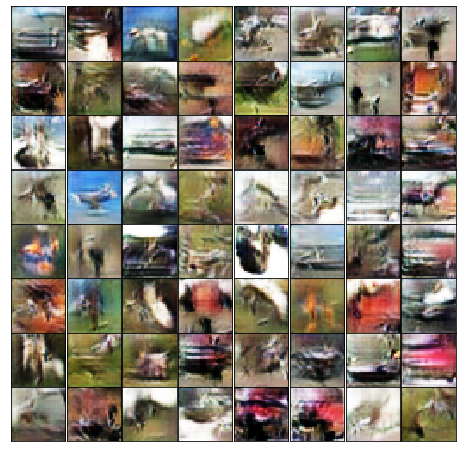

In [1]:
"""
Run for evaluation purposes (works even if above cells are not executed)
"""

import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

GRID_SIZE = 8
GRID_IMGS = GRID_SIZE ** 2
LATENT_DIM = 100


def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)


def plot_final_grid(generated_images):
    """
    Plots the grid of images generated from final model
    :param generated_images: List of generated images (atleast GRID_IMGS)
    :return: None
    """

    fig = plt.figure(figsize=(GRID_SIZE, GRID_SIZE))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.001, hspace=0.001)

    for ind in range(GRID_IMGS):
        ax = fig.add_subplot(GRID_SIZE, GRID_SIZE, ind + 1, xticks=[], yticks=[])
        ax.imshow(np.uint8(((generated_images[ind] + 1) / 2) * 255), cmap='gray')

    plt.savefig('./SAGAN/generated_image_grid.png')
    plt.savefig('./results/SAGAN.png')
    plt.show()


def generate_latent_samples(n_samples, sample_size):  
    """
    Creates latent samples to be fed into the generator
    :param n_samples: Number of samples to be generated
    :param sample_size: Dimesion on each sample
    :return: Latent samples of given size
    """
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))


# Load best generator model
generator = load_model('./model/SAGAN/best_generator') 
 
# Pot GRID_IMGS generated images from the model in a GRID_SIZE by GRID_SIZE grid 
random_labels  = np.random.randint(0, 10, 64).reshape(-1, 1)
gan_images = generator.predict((generate_latent_samples(64, 100), random_labels))
plot_final_grid(gan_images)